In [ ]:
# Load Data
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install transformers torch

In [ ]:
from transformers import BertTokenizer, BertModel,BertForSequenceClassification, XLMRobertaForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaModel, XLMRobertaTokenizer, AutoTokenizer
from transformers import AutoTokenizer, XLMRobertaXLModel
from transformers import XLMRobertaConfig, XLMRobertaModel

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import pandas as pd
import numpy as np
import torch

## 1. Define DataSet and Dataloaders for Claims Text

In [ ]:
class BertDataset(Dataset):
    def __init__(self, csv_file,label_map, tokenizer, max_length=512):
        self.data_frame = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = label_map
        # redefine self.data_frame for integer valued labels
        self.data_frame['status'] = self.data_frame['status'].map(self.label_map)

    def __len__(self):
        return self.data_frame.shape[0]

    def __getitem__(self, idx):
        #text = self.data_frame.iloc[idx]['claims']
        text = self.data_frame.iloc[idx]['abstracts'] #text_patentability_data.csv

        label = self.data_frame.iloc[idx]['status']

        # Encoding the text using the BERT tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
input_path = '/content/drive/MyDrive/text_df.csv' #CHANGE for Dataset /content/drive/MyDrive/text_df_small.csv /content/drive/MyDrive/abstracts_df_small.csv
MODEL_NAME = 'xlm-roberta-large' #xlm-roberta-xlarge xlm-roberta-base
# Load the dataset
label_map = {'ABN': 0, 'ISS': 1, 'PEND':0}
dataset = BertDataset(input_path, label_map=label_map, tokenizer=AutoTokenizer.from_pretrained(MODEL_NAME))

# Example dataset size
total_size = len(dataset)

# Define the proportions
train_size = int(0.95* total_size)
val_size = int(0.025* total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# define dataloaders
BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

9440
248
249


## 2. Fine Tune Pretrained BERT

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import tensorflow as tf

# Number of epochs
num_epochs = 20

# load model for BERT classification
model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Scheduler
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}


        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()



model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3. Evaluate BERT Performance on validation set

In [ ]:
# store predictions in list
val_predictions = []
val_labels = []

# set model to evaluation mode: evaluation loop
model.eval()
with torch.no_grad():
    for batch in val_dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        # Get predictions
        predictions = torch.argmax(logits, dim=1)
        labels = batch['labels']

        # Store predictions
        val_predictions.extend(predictions.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

In [ ]:
# Use SKLearn library to predict F1, Precision, Recall
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score

f1 = f1_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
accuracy = accuracy_score(val_labels, val_predictions)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.7096774193548387
F1 Score: 0.7857142857142858
Precision: 0.8048780487804879
Recall: 0.7674418604651163


164
84


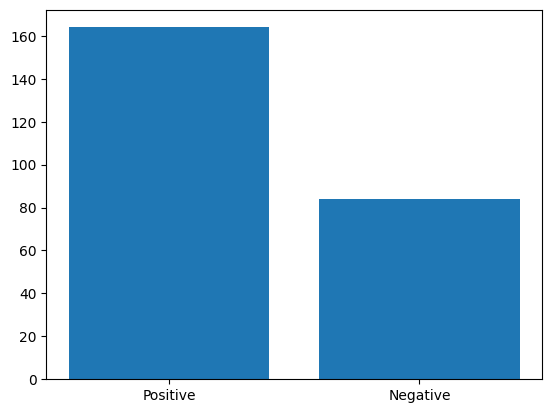

In [ ]:
# Plot the proportion of positive vs. negative predictions
import matplotlib.pyplot as plt

print(val_predictions.count(1))
print(val_predictions.count(0))

plt.bar(['Positive', 'Negative'], [val_predictions.count(1), val_predictions.count(0)])
plt.show()